In [1]:
from __future__ import division

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from matplotlib import finance

%matplotlib inline

# Loading and Exploring the Data

In [2]:
data = pd.read_csv('WIKI_20160608.csv', names=['Ticker', 'Date', 'Open', 'High', 'Low', 'Close',
                                              'Volume', '7', '8', 'Adj-O', 'Adj-H', 'Adj-L', 'Adj-C',
                                              'Adj-Vol'])

In [3]:
data.head(5)

,Ticker,Date,Open,High,Low,Close,Volume,7,8,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol
0,A,1999-11-18,45.50,50.00,40.00,44.00,44739900.0,0.0,1.0,43.584507,47.895063,38.316050,42.147655,44739900.0
1,A,1999-11-19,42.94,43.00,39.81,40.38,10897100.0,0.0,1.0,41.132280,41.189754,38.134049,38.680053,10897100.0
2,A,1999-11-22,41.31,44.00,40.06,44.00,4705200.0,0.0,1.0,39.570901,42.147655,38.373524,42.147655,4705200.0
3,A,1999-11-23,42.50,43.63,40.25,40.25,4274400.0,0.0,1.0,40.710803,41.793232,38.555525,38.555525,4274400.0
4,A,1999-11-24,40.13,41.94,40.00,41.06,3464400.0,0.0,1.0,38.440577,40.174379,38.316050,39.331425,3464400.0


Create a new dataframe with only the adjusted data, data, & ticker symbol.

In [4]:
dat = data[['Ticker', 'Date', 'Adj-O', 'Adj-H', 'Adj-L', 'Adj-C', 'Adj-Vol']]

In [5]:
dat.head(5)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol
0,A,1999-11-18,43.584507,47.895063,38.316050,42.147655,44739900.0
1,A,1999-11-19,41.132280,41.189754,38.134049,38.680053,10897100.0
2,A,1999-11-22,39.570901,42.147655,38.373524,42.147655,4705200.0
3,A,1999-11-23,40.710803,41.793232,38.555525,38.555525,4274400.0
4,A,1999-11-24,38.440577,40.174379,38.316050,39.331425,3464400.0


In [6]:
dat.shape

(14150093, 7)

Create a dataframe for a specific ticker

In [7]:
agilent = dat[dat['Ticker'] == 'A']

In [8]:
agilent.head()

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol
0,A,1999-11-18,43.584507,47.895063,38.316050,42.147655,44739900.0
1,A,1999-11-19,41.132280,41.189754,38.134049,38.680053,10897100.0
2,A,1999-11-22,39.570901,42.147655,38.373524,42.147655,4705200.0
3,A,1999-11-23,40.710803,41.793232,38.555525,38.555525,4274400.0
4,A,1999-11-24,38.440577,40.174379,38.316050,39.331425,3464400.0


Pretty straight forward to get a ticker specific set of data.  Below I will create a function to automate the process.

In [9]:
def tick_gettr(ticker):
    data = dat[dat['Ticker'] == ticker]
    return data

I will also create an array for all tickers in the dataset in case that comes in handy.

In [10]:
tickers = dat['Ticker']
tickers = tickers.unique()
len(tickers)

3179

Now I will get a ticker specific set of data to work with.

In [11]:
aapl = tick_gettr('AAPL')

## Basic Calculations

I first need to create the RSI components and determine how many days my moving average will be built with.

I will begin by creating the relative strength component.  Instead of hardcoding a number of days for the moving average I want to be able to look at different averages.  Below I will write a couple of functions to create the RSI.

RS:

In [12]:
def rs(ticker, look_back):
    """
    A function to find the relative strength of a stock using a user specified
    look back period.
    """
    
    #Get the difference between consecutive adjusted closes.
    difference = ticker['Adj-C'].diff()
    difference = difference[1:]
    
    #Define & clean up the up sessions & down sessions.
    up, down = difference.copy(), difference.copy()
    
    up[up < 0] = 0
    down[down > 0] = 0
    
    #Get the absolute value for the down sessions.
    down = down.abs()
    
    #Get the look_back mean for both up & down sessions.
    upper = up.rolling(window=look_back, center=False).mean()
    downer = down.rolling(window=look_back, center=False).mean()
        
    #Calculate the relative strength
    rs = upper / downer
    
    return rs

RSI:

In [13]:
def rsi(ticker, look_back):
    """
    A function that determines the relative strength index of a specific stock.
    """
    
    #Get the relative strength.
    r_s = rs(ticker, look_back)
    #Calculate the RSI.
    rsi = 100.0 - 100.0 / (1.0 + r_s)

    return rsi.round(decimals=2)

The Python code to get the RS calculation was greatly informed from this StackOverflow answer:

##### http://stackoverflow.com/a/29400434/1094634

Also important to note, that some sources will calculate some elements of the RSI differently.  Yahoo Finance & ThinkorSwim for instances calculate it the same (and differently from the above calculation) while Freestockcharts.com (Worden) calculates it the same way as the above functions.

### Buy/Sell Rule:

I will need some rules to determine when to buy & when to sell.  I will begin with a simple buy/sell rule.  Buy @ the closing price when RSI < 30 & sell @ the closing price when RSI > 70.  The 30 & 70 thresholds are the traditional demarcation points for 'oversold' (<30) & 'overbought' (>70) while using the RSI.  These thresholds are ripe for fine tuning.  Initially, I will be using the 14 day average.  The other average that I want to look at is the 9 day.  As with the oversold/overbought level, the optimal average needs to be tested/tuned as well.

Simply, what I want to know is if the RSI predicts higer prices from the buy point.  The actual price itself is not very important (although will be useful.)  If the sell price is consistently higher than the buy price, then I will interpret that as the RSI having some predictive value (whether or not the RSI strategy is more profitable than simply buying & holding the S&P 500 or the individual issues I use is a separate question.)


First, I will get Apples (AAPL) RSI using the 14 day average.

In [14]:
aapl_rsi = rsi(aapl, 14)

Now I want to add a new column to the dataset to include the RSI

In [15]:
aapl['RSI'] = aapl_rsi

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [16]:
aapl.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
39644,AAPL,1980-12-12,0.436051,0.437871,0.436051,0.436051,117258400.0,NaN
39645,AAPL,1980-12-15,0.415273,0.415273,0.413301,0.413301,43971200.0,NaN


Next I want to remove the first 14 columsn with NaNs for the RSI

In [17]:
aapl = aapl[14:]

In [18]:
aapl.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.5
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.5


Now I want to create some more columns that will show the prices for days where the RSI is < 30 & > 70.  Since I am going to do this repeatedly, I want to create a function to handle this process.

In [19]:
def price_columns(data, overbot, oversold):
    """
    A function that adds and populates the 'Sell Price' and 'Buy Price' columns for
    the dataset that is being used.
    
    overbot & oversold are ints
    """
    number_observations = len(data)
    data['Sell Price'] = pd.Series(0, np.arange(number_observations))
    #Populate the 'Sell Price' column with the relevant overbought data.
    data.ix[data.RSI > overbot, 'Sell Price'] = data['Adj-C']
    data['Buy Price'] = pd.Series(0, np.arange(number_observations))
    #Populate the 'Buy Price' column with the relevant oversold data.
    data.ix[data.RSI < oversold, 'Buy Price'] = data['Adj-C']
    
    return data

In [20]:
aapl = price_columns(aapl, 70, 30)

In [21]:
aapl.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.5,NaN,NaN
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.5,NaN,NaN


Since I will also be prepping the data for multiple datasets repeatedly I want to the RSI prep work above automatically as well.  I will write a function to handle prepping the data to include the RSI column.

In [22]:
def rsi_add(data, ave_length):
    """
    A function that will call rsi() to create the relevant RSI data & then add
    the RSI column to the relevant dataset.
    
    ave_length is a int
    """
    data_rsi = rsi(data, ave_length)
    data['RSI'] = data_rsi
    data = data[ave_length:]
    
    return data

I will also create several columns that represent holding periods of 1, 3, 5, & 10 days.  I think it will be beneficial to see whether or not arbitrary holding periods show better returns then the RSI > 70 sell point.  These holding periods can be played with and they are picked to represent the shorter term nature of this type of trade.

In [23]:
base = aapl.copy()
base = base['Adj-C']

day_1 = base.shift(-1)
day_3 = base.shift(-3)
day_5 = base.shift(-5)
day_10 = base.shift(-10)

In [24]:
aapl['Day 1'] = day_1
aapl['Day 3'] = day_3
aapl['Day 5'] = day_5
aapl['Day 10'] = day_10

In [25]:
aapl.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.5,NaN,NaN,0.489136,0.458802,0.479581,0.498539
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.5,NaN,NaN,0.468357,0.483524,0.462594,0.483524


Now I have a dataset to begin working with.

# Analyzing the Data

### A simple and naive regression

First I am going to run a simple regression of the RSI column against the adjusted close column to see what that looks like.

In [26]:
aapl_prices = aapl[['Adj-C']]
aapl_rsi_d = aapl[['RSI']]

### Splitting the training & test data.

I will do this automatically as well, but since the historical order of the data is important I will write a function to handle this.  I want to train the model on the older data and test it on the newer data to see if there is any predictive abilities.  A **caveat** here, however, this where many of these types of strategies and analytical approaches end up overfitting and producing models the have *disatsrous* results in the real world.

In [27]:
def train_test(data, features, prediction, train):
    """
    A function that splits the dataset into training & testing sets while preserving chronological order.
    
    features = a list of strs that are going to used to train the models.
    prediction = a list of a str that the model will be attempting to predict.
    train = a float that represents the % of the dataset used for the training set.
    """
    #Create our features & predictions
    data_preds = data[prediction]
    data_feats = data[features]
    
    #Use the train percent to get an int that will represent the index cut off point for
    #the data sets
    train_percent = int(round(len(data) * train))
    
    #Split the features & predictions into their train/test splits
    train_preds = data_preds[:train_percent]
    train_feats = data_feats[:train_percent]
    test_preds = data_preds[train_percent:]
    test_feats = data_feats[train_percent:]
    
    return train_preds, train_feats, test_preds, test_feats

In [28]:
aapl_preds, aapl_feats, aapl_testp, aapl_testf = train_test(aapl, ['RSI'], ['Adj-C'], .8)

Now I will create a simple, naive linear regression model

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
simple_linear = LinearRegression()
simple_linear.fit(aapl_feats, aapl_preds)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
predicted_price = simple_linear.predict(aapl_testf)

In [32]:
simple_linear.score(aapl_testf, aapl_testp)

-4.4864101023722318

Not a very good score.

Let's see what the RSS is.

In [33]:
np.sum((predicted_price - aapl_testp) ** 2)

Adj-C    9.356749e+06
dtype: float64

That's a pretty large number, again not a very good result for this very simplistic regression model.

I want to plot this out to see what these predicted results look like.

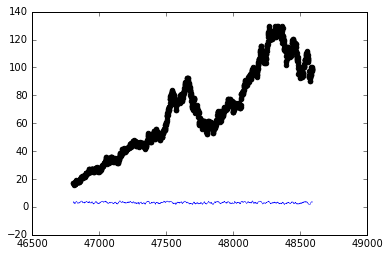

In [34]:
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.plot(aapl_testf.index, predicted_price, color='blue', linewidth=.5)

Obviously simply using the RSI values without any type of filter to predict prices is not effective.

Now I will use a number of features to see what the result is.

In [35]:
multi_naive_features = ['Adj-O', 'Adj-H', 'Adj-L', 'Adj-Vol', 'RSI']

In [36]:
aapl_preds, aapl_feats, aapl_testp, aapl_testf = train_test(aapl, multi_naive_features, ['Adj-C'], .8)

In [37]:
multi_simple_linear = LinearRegression()
multi_simple_linear.fit(aapl_feats, aapl_preds)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
predicted_price = multi_simple_linear.predict(aapl_testf)

Check the regression score:

In [39]:
multi_simple_linear.score(aapl_testf, aapl_testp)

0.99981783502231891

Now calculate the RSS:

In [40]:
np.sum((predicted_price - aapl_testp) ** 2)

Adj-C    310.671642
dtype: float64

This seems a little too good, so now I will plot my predictions.

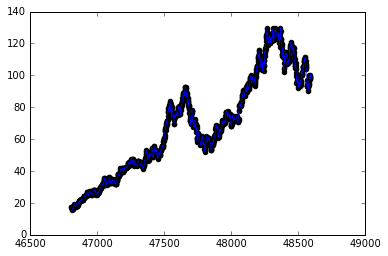

In [41]:
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.plot(aapl_testf.index, predicted_price, color='blue', linewidth=.5)

Where in the first naive regression I had no correlation whatsoever, this one seems to be too good to be true.

Now I what to use the RSI buy/sell thresholds in order to see if I these thresholds are predictive.  I will use linear regression and decision tree regression.

First I want to create another column that will show the post buy sell signal price.  I want to keep a sell column as well, since it theoretically possible to use the overbought signal as signal to short.  Anecdotally the short signal using RSI hasn't not been considered very successful and any number of theories as to why have been floated, however, I have never tested this and want to keep that option open.

I will create another new column, 'Sell Signal Price', which will hold the closing price when the sell signal is generated.  I will again create a function to create this column and then populate it.

In [42]:
def sell_signal_prices(data, overbot, oversold):
    """
    This function will create the 'Sell Signal Column' and populate it with data.
    
    overbot & oversold are ints that will used as the relevant thresholds for the RSI.
    """
    
    observations = len(data)
    #Create an empty column and replace the NaNs with 0s.
    data['Sell Signal Price'] = pd.Series(0, np.arange(observations))
    data = data.fillna(0)
    
    #Create a temporary dataframe.
    temp_frame = data[['Adj-C', 'RSI', 'Sell Price', 'Buy Price', 'Sell Signal Price']]
    
    #Loop through the temporary dataframe to populate the 'Sell Signal Price' column with data.
    for price in temp_frame.iterrows():
        if 0 < price[1][1] < oversold:
            place = temp_frame.query(price[0])
            p_start = temp_frame.index.get_loc(place.name)
            temp_list = temp_frame[p_start:]

            for i in temp_list.iterrows():
                if i[1][1] > overbot:
                    price[1][4] = i[1][0]
                    break
    
    #Populate the new column in the original dataframe with the sell price data.
    data['Sell Signal Price'] = temp_frame['Sell Signal Price']
    
    return data

Now I will test the new function with the aapl dataset.  I know location of the first RSI < 30 observation so I will use that observation to see if the function works.

In [43]:
aapl.iloc[9]

Ticker              AAPL
Date          1981-01-16
Adj-O           0.471997
Adj-H           0.471997
Adj-L           0.470177
Adj-C           0.470177
Adj-Vol       3.3488e+06
RSI                29.55
Sell Price           NaN
Buy Price       0.470177
Day 1           0.498539
Day 3           0.492928
Day 5           0.496719
Day 10          0.428468
Name: 39667, dtype: object

In [44]:
aapl = sell_signal_prices(aapl, 70, 30)

In [45]:
aapl.iloc[9]

Ticker                     AAPL
Date                 1981-01-16
Adj-O                  0.471997
Adj-H                  0.471997
Adj-L                  0.470177
Adj-C                  0.470177
Adj-Vol              3.3488e+06
RSI                       29.55
Sell Price                    0
Buy Price              0.470177
Day 1                  0.498539
Day 3                  0.492928
Day 5                  0.496719
Day 10                 0.428468
Sell Signal Price      0.399954
Name: 39667, dtype: object

Success!

Now I want to use this dataset to run some regressions using linear regression and decision tree regeression.

## Running the Regeressions

First I will choose which features I want to use and then I will split up my train/test data.

In [48]:
rsi_features = ['RSI', 'Buy Price']

aapl_preds, aapl_feats, aapl_testp, aapl_testf = train_test(aapl, rsi_features, ['Sell Signal Price'], .8)

### Linear Regression

In [49]:
rsi_30_model = LinearRegression()
rsi_30_model.fit(aapl_feats, aapl_preds)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [52]:
predicted30_prices = rsi_30_model.predict(aapl_testf)

Score & RSS:

In [51]:
rsi_30_model.score(aapl_testf, aapl_testp)

0.98512976758219584

In [53]:
np.sum((predicted30_prices - aapl_testp) ** 2)

Sell Signal Price    11671.091729
dtype: float64

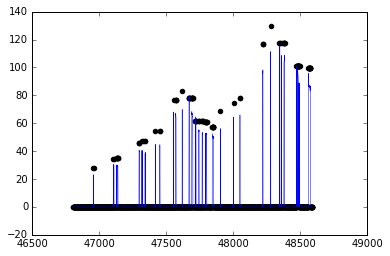

In [56]:
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.plot(aapl_testf.index, predicted30_prices, color='blue', linewidth=.5)

### Decision Tree Regression

I am going to use three different max depths (2, 5, 20.)

In [57]:
from sklearn.tree import DecisionTreeRegressor

In [58]:
trereg_2 = DecisionTreeRegressor(max_depth=2)
trereg_5 = DecisionTreeRegressor(max_depth=5)
trereg_20 = DecisionTreeRegressor(max_depth=20)

In [59]:
trereg_2.fit(aapl_feats, aapl_preds)
trereg_5.fit(aapl_feats, aapl_preds)
trereg_20.fit(aapl_feats, aapl_preds)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [60]:
predict_2 = trereg_2.predict(aapl_testf)
predict_5 = trereg_5.predict(aapl_testf)
predict_20 = trereg_20.predict(aapl_testf)

Now I want to see the scores & RSSs.

First I have to clean up the test prices.

In [64]:
testp_matrix = aapl_testp.as_matrix(columns=['Sell Signal Price'])
testp_matrix = testp_matrix.reshape((1787, ))

Max depth 2:

In [61]:
trereg_2.score(aapl_testf, aapl_testp)

0.29166041143263166

In [65]:
np.sum((predict_2 - testp_matrix) ** 2)

555949.3679156045

Max depth 5:

In [62]:
trereg_5.score(aapl_testf, aapl_testp)

0.27080168559486484

In [66]:
np.sum((predict_5 - testp_matrix) ** 2)

572320.60514729063

Max depth 20:

In [68]:
trereg_20.score(aapl_testf, aapl_testp)

0.31505284909642939

In [67]:
np.sum((predict_2 - testp_matrix) ** 2)

555949.3679156045

Better than the naive regression I ran further up, but fairly mediocre.

Now I will plot these to see what they look like.

First, max depth 2:

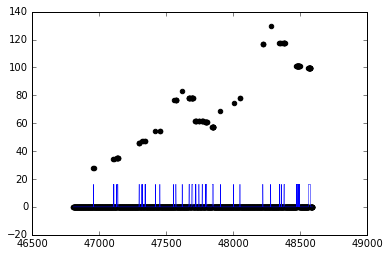

In [69]:
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.plot(aapl_testf.index, predict_2, color='blue', linewidth=.5)

Max depth 5:

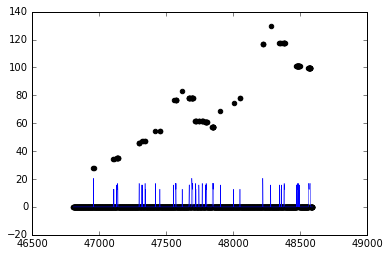

In [70]:
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.plot(aapl_testf.index, predict_5, color='blue', linewidth=.5)

Max depth 20:

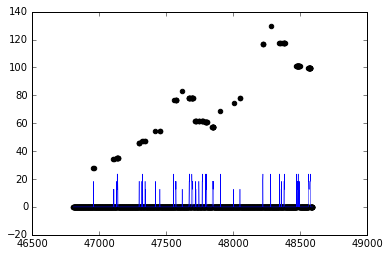

In [71]:
plt.scatter(aapl_testf.index, aapl_testp, color='black')
plt.plot(aapl_testf.index, predict_20, color='blue', linewidth=.5)

Not very impressive results.